In [1]:
# for the model
from sequence_jacobian.examples.hank import *

# for data generation
from sequence_jacobian.utilities.shocks import simulate
from sequence_jacobian.utilities.plotting import *

# for likelihood evaluation
import sequence_jacobian.estimation as sje

In [2]:
from sequence_jacobian import create_model, ShockDict, Uniform, Prior, AR
import optimagic as om
import numpy as np

In [3]:
household = hh.add_hetinputs([transfers, wages, make_grids])
household = household.add_hetoutputs([labor_supply])

blocks = [household, firm, monetary, fiscal, mkt_clearing, nkpc]
hank_model = create_model(blocks, name="One-Asset HANK")

In [4]:
calibration = {
    "r": 0.005,
    "rstar": 0.005,
    "eis": 0.5,
    "frisch": 0.5,
    "B": 5.6,
    "mu": 1.2,
    "rho_s": 0.966,
    "sigma_s": 0.5,
    "kappa": 0.1,
    "phi": 1.5,
    "Y": 1.0,
    "Z": 1.0,
    "pi": 0.,
    "nS": 2,
    "amax": 150,
    "nA": 10
}

In [5]:
unknowns_ss = {"beta": 0.986, "vphi": 0.8}
targets_ss = {"asset_mkt": 0.0, "NE": 1.0}

blocks_ss = [household, firm, monetary, fiscal, mkt_clearing, nkpc_ss]
hank_model_ss = create_model(blocks_ss, name="One-Asset HANK SS")

cali = hank_model_ss.solve_steady_state(
    calibration, unknowns_ss, targets_ss, solver="broyden_custom"
)

ss = hank_model.steady_state(cali)

In [6]:
unknowns = ["w", "Y", "pi"]
targets = ["asset_mkt", "goods_mkt", "nkpc_res"]
inputs = ["rstar", "Z"]
outputs = ["Y", "pi"]
T = 500

In [7]:
shocks = ShockDict({
    "rstar": AR(np.array([0.7]), 1.0),
    "Z": AR(np.array([0.8]), 0.5)
})

ar_prior = Prior({
    "phi": Uniform(-0.99, 0.99),
    "sigma": Uniform(0.05, 1.5)
})

shock_prior = Prior({i: ar_prior for i in inputs})

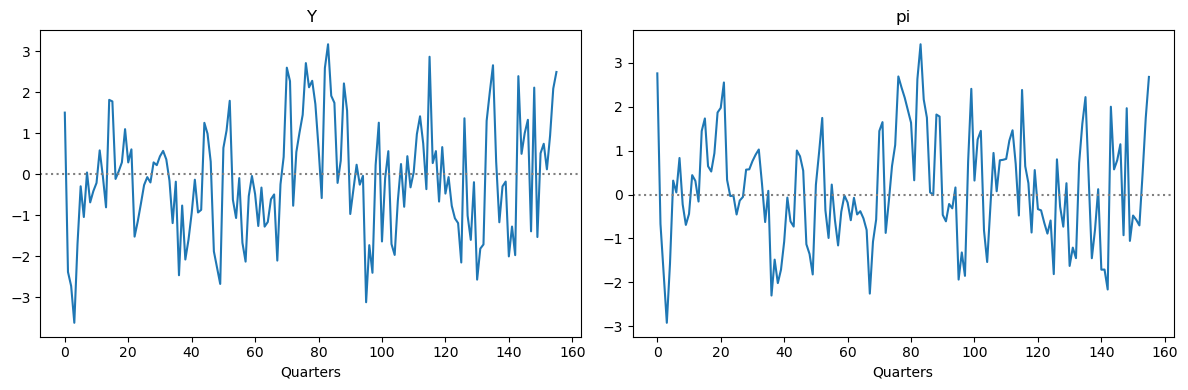

In [8]:
G = hank_model.solve_jacobian(ss, unknowns, targets, inputs, outputs, T=T)

impulses = shocks.generate_impulses(T)
irfs = {i: G @ {i: impulses[i]} for i in inputs}

data_simul = simulate(list(irfs.values()), outputs, 156)
plot_timeseries(data_simul, figsize=(12, 4))

Y = np.empty((156, len(outputs)))
for no, o in enumerate(outputs):
    Y[:, no] = data_simul[o]

In [9]:
def log_likelihood(shocks, data, parameters):
    # reparameterize shocks
    shocks.reparameterize(parameters)

    # construct impulse response functions
    impulses = shocks.generate_impulses(T)
    irfs = {i: G @ {i: impulses[i]} for i in inputs}
    
    M = np.empty((T, len(outputs), len(inputs)))
    for no, o in enumerate(outputs):
        for ns, s in enumerate(inputs):
            M[:, no, ns] = irfs[s][o]
    
    # approximate the autocovariances
    Sigma = sje.all_covariances(M, 1)
    
    # compute the log posterior likelihood
    return sje.log_likelihood(data, Sigma)

In [10]:
# for now construct the prior by hand
prior_support = om.Bounds(
    lower = {i: {"phi": -0.99, "sigma": 0.05} for i in inputs},
    upper = {i: {"phi": 0.99, "sigma": np.inf} for i in inputs},
)

In [11]:
# nelder-meade works the most consistently
result = om.maximize(
    lambda theta: log_likelihood(shocks, Y, theta),
    shock_prior.rand(),
    bounds = prior_support,
    algorithm = "scipy_neldermead"
)

In [12]:
result.x

{'Z': {'phi': 0.7329611442647008, 'sigma': 0.5492586229418619},
 'rstar': {'phi': 0.6804353366916704, 'sigma': 1.1166742443012017}}

# Custom RWMH

In [32]:
# reset the shocks
shocks = ShockDict({
    "rstar": AR(np.array([0.7]), 1.0),
    "Z": AR(np.array([0.8]), 0.5)
})

def log_posterior(parameters):
    logpost  = log_likelihood(shocks, Y, parameters)
    logprior = shock_prior.logpdf(parameters)
    return logpost + logprior

In [40]:
def independent_random_walk(state, scale=0.025):
    new_state = {}
    for key, value in state.items():
        if isinstance(value, dict):
            new_state[key] = {}
            for subkey in value.keys():
                new_state[key][subkey] = np.random.normal(
                    loc = state[key][subkey],
                    scale = scale
                )
        else:
            new_state[key] += np.random.normal(
                loc = state[key],
                scale = scale
            )
    
    return new_state

def mh_iter(state, logprob, likelihood, **kwargs):
    proposed_state   = independent_random_walk(state, **kwargs)    
    proposal_logprob = likelihood(proposed_state)
    alpha = np.min((1, np.exp(proposal_logprob - logprob)))
    
    if alpha >= np.random.uniform(0, 1):
        return proposed_state, proposal_logprob

    return state, logprob

In [41]:
# draw blindly from the prior
theta = shock_prior.rand()
logprob = log_posterior(theta)

# rerun the Jacobian
G = hank_model.solve_jacobian(ss, unknowns, targets, inputs, outputs, T=T)

# no burn-in for demonstrative purposes
burn_in = 0.0
n_samples = 1000

# begin iteration
samples = []
for i in range(n_samples):
    theta, logprob = mh_iter(theta, logprob, log_posterior)
    
    if i >= burn_in*n_samples:
        samples.append(theta)

In [42]:
import matplotlib.pyplot as mpl
import pandas as pd

params = pd.concat(pd.DataFrame(d) for d in samples)

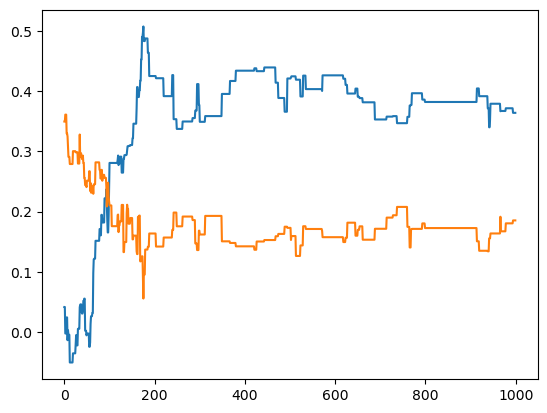

In [43]:
mpl.plot(params["Z"]["phi"].to_list())
mpl.plot(params["rstar"]["phi"].to_list())

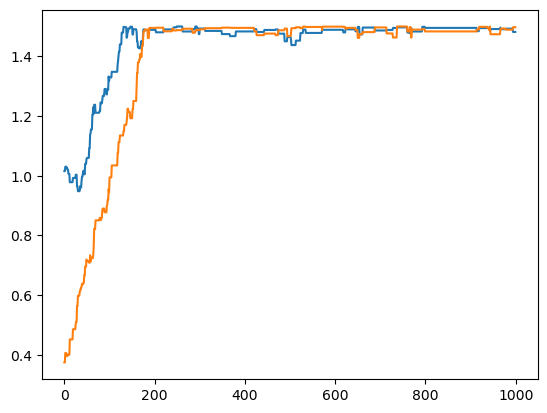

In [44]:
mpl.plot(params["Z"]["sigma"].to_list())
mpl.plot(params["rstar"]["sigma"].to_list())

In [31]:
theta

{'Z': {'phi': 0.6827362474547942, 'sigma': 1.059550860661735},
 'rstar': {'phi': -0.6092084530419143, 'sigma': 1.373937971193322}}